## Speech Recognition with Neural Networks

Some of the files in this notebook are taken from this [github](https://github.com/baidu-research/ba-dls-deepspeech)

- [flac_to_wav.sh](https://github.com/baidu-research/ba-dls-deepspeech/blob/master/flac_to_wav.sh)
- [create_desc_json.py](https://github.com/baidu-research/ba-dls-deepspeech/blob/master/create_desc_json.py)
- [char_map.py](https://github.com/baidu-research/ba-dls-deepspeech/blob/master/char_map.py)
---

## Data

We can download training, testing and validation data from [data](http://www.openslr.org/12/). 

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.

---

In [38]:
import wget
import tarfile

%matplotlib inline

In [39]:
DATA_PATH = "D:/Data_ASR/"

### Download data

In [24]:
base="http://www.openslr.org/resources/12/"

for s in ['dev-clean','dev-other','test-clean','test-other','train-clean-100','train-clean-360','train-other-500']:
    url = "{}{}.tar.gz".format(base, s)
    print('\nCurrent download: ' + url)
    wget.download(url, DATA_PATH)


Current download: http://www.openslr.org/resources/12/dev-clean.tar.gz
100% [......................................................................] 337926286 / 337926286
Current download: http://www.openslr.org/resources/12/dev-other.tar.gz
100% [......................................................................] 314305928 / 314305928
Current download: http://www.openslr.org/resources/12/test-clean.tar.gz
100% [......................................................................] 346663984 / 346663984
Current download: http://www.openslr.org/resources/12/test-other.tar.gz
100% [......................................................................] 328757843 / 328757843
Current download: http://www.openslr.org/resources/12/train-clean-100.tar.gz
100% [....................................................................] 6387309499 / 6387309499
Current download: http://www.openslr.org/resources/12/train-clean-360.tar.gz
100% [.....................................................

### Uncompress data

In [30]:
for s in ['dev-clean','test-clean']:
    file = "{}{}.tar.gz".format(DATA_PATH, s)
    print('\nCurrent file: ' + file)
    tar = tarfile.open(file)
    tar.extractall(DATA_PATH)


Current file: D:/Data_ASR/dev-clean.tar.gz

Current file: D:/Data_ASR/test-clean.tar.gz


### Convert .flac files to .wav

In [69]:
import shutil

In [70]:
shutil.copy2('flac_to_wav.sh', DATA_PATH + 'LibriSpeech')

'D:/Data_ASR/LibriSpeech\\flac_to_wav.sh'

- Open Cygwin Terminal (Make sure ffmpeg is installed)
- CD to DATA_PATH + LibriSpeech
- run ./flac_to_wav.sh

Installation guide for [ffmpeg](http://www.mediaentertainmentinfo.com/2014/01/1-technical-series-how-to-compile-ffmpeg-under-cygwin.html)

## Spectrogram

In [40]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import os
import IPython
from scipy.io import wavfile 
import matplotlib.pyplot as plt
import json
import random
%matplotlib inline

In [41]:
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)  # rate=44100 - sampling rate (https://en.wikipedia.org/wiki/44,100_Hz)
    
    nfft = 320          # fft window length
    fs = 8000           # sampling frequency
    noverlap = 160      # overlap between windows
    nchannels = data.ndim
    
    if nchannels == 1:
        pxx, freq, bins, im = plt.specgram(data, nfft, fs, noverlap=noverlap)
    elif nchannels == 2:
        pxx, freq, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap=noverlap)
    
    return pxx, freq

Power shape: (161, 584)
Freq shape: (161,)


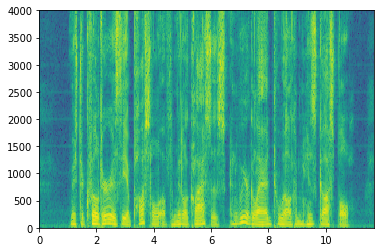

In [126]:
p, f = graph_spectrogram(DATA_PATH + 'LibriSpeech/dev-clean/1272/128104/1272-128104-0000.wav')
print('Power shape: ' + str(p.shape))
print('Freq shape: ' + str(f.shape))

Power shape: (161, 900)
Freq shape: (161,)


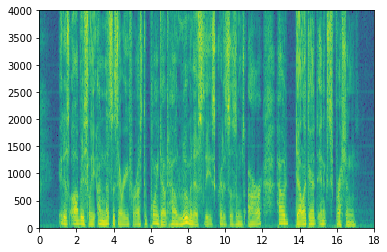

In [127]:
p, f = graph_spectrogram(DATA_PATH + 'LibriSpeech/dev-clean/1272/128104/1272-128104-0005.wav')
print('Power shape: ' + str(p.shape))
print('Freq shape: ' + str(f.shape))

#### We need to keep focus on 161. These are the feature on which we have to train our model.

In [151]:
from char_map import char_map, index_map

In [152]:
def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [154]:
print(text_to_int_sequence('this is a text'))

[22, 10, 11, 21, 2, 11, 21, 2, 3, 2, 22, 7, 26, 22]


## Deep Neural Network for Acoustic Modeling

In [137]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, CuDNNGRU
from keras.optimizers import Adam

#### Model: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [142]:
def model(input_dim):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_dim -- dim of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = (None, input_dim), name='input')
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)             # CONV1D
    X = BatchNormalization(axis=-1)(X)                  # Batch normalization
    X = Activation('relu')(X)                           # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = CuDNNGRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(29, activation = "softmax"))(X) # time distributed  (softmax)

    model = Model(inputs = X_input, outputs = X)

    return model

In [143]:
model = model(input_dim=161)

#### Create JSON files corresponding to the train and validation datasets 

In [146]:
import json
import os
import wave

In [147]:
def desc_json(data_directory, output_file):
    labels = []
    durations = []
    keys = []
    for group in os.listdir(data_directory):
        speaker_path = os.path.join(data_directory, group)
        for speaker in os.listdir(speaker_path):
            labels_file = os.path.join(speaker_path, speaker,
                                       '{}-{}.trans.txt'
                                       .format(group, speaker))
            for line in open(labels_file):
                split = line.strip().split()
                file_id = split[0]
                label = ' '.join(split[1:]).lower()
                audio_file = os.path.join(speaker_path, speaker,
                                          file_id) + '.wav'
                audio = wave.open(audio_file)
                duration = float(audio.getnframes()) / audio.getframerate()
                audio.close()
                keys.append(audio_file)
                durations.append(duration)
                labels.append(label)
    with open(output_file, 'w') as out_file:
        for i in range(len(keys)):
            line = json.dumps({'key': keys[i], 'duration': durations[i],
                              'text': labels[i]})
            out_file.write(line + '\n')

In [148]:
desc_json(DATA_PATH + 'LibriSpeech/dev-clean/', DATA_PATH + 'train_corpus.json')
desc_json(DATA_PATH + 'LibriSpeech/test-clean/', DATA_PATH + 'valid_corpus.json')

#### Create Class AudioGenerator

In [52]:
class AudioGenerator():
    
    def __init__(self, minibatch_size=20, max_duration=10.0, sort_by_duration=False):
        self.minibatch_size = minibatch_size
        self.max_duration = max_duration
        self.sort_by_duration = sort_by_duration
        self.rng = random.Random(0)
        
    def load_train_data(self, desc_file='train_corpus.json'):
        try:
            self.__load_metadata_from_desc_file(desc_file, 'train')
            self.__fit_train()
        except Exception as e:
            raise Exception(e)
    
    def load_validation_data(self, desc_file='valid_corpus.json'):
        try:
            self.__load_metadata_from_desc_file(desc_file, 'validation')
        except Exception as e:
            raise Exception(e)
            
    def load_test_data(self, desc_file='test_corpus.json'):
        try:
            self.__load_metadata_from_desc_file(desc_file, 'test')
        except Exception as e:
            raise Exception(e)
            
    # private method
    def __normalize(self, feature, epsilon=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + epsilon)
            
    # private method
    def __text_to_int_seq(self, text):
        """ Convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = char_map['<SPACE>']
            else:
                ch = char_map[c]
            int_sequence.append(ch)
        return int_sequence

    # private method
    def __graph_spectrogram_from_wav(self, wav):
        p, f = graph_spectrogram(wav)
        return np.transpose(p)

    # private method
    def __fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.__graph_spectrogram_from_wav(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    # private method
    def __load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        
        try:
            with open(desc_file) as json_file:
                for line_num, json_line in enumerate(json_file):
                    try:
                        line = json.loads(json_line)
                        # if file content are bigger then skip
                        if float(line['duration']) > self.max_duration:
                            continue
                        audio_paths.append(line['key'])
                        durations.append(float(line['duration']))
                        texts.append(line['text'])
                
                    except Exception as e:
                        raise Exception('Error at line {}. Exception: {}'.format(line_num, e))
                
            if partition == 'train':
                self.train_audio_paths = audio_paths
                self.train_durations = durations
                self.train_texts = texts
            elif partition == 'validation':
                self.valid_audio_paths = audio_paths
                self.valid_durations = durations
                self.valid_texts = texts
            elif partition =='test':
                self.test_audio_paths = audio_paths
                self.test_durations = durations
                self.test_texts = texts
            else:
                print('Invalid partition selected.. Valid partions: train/test/validation')
                        
        except Exception as e:
            raise Exception(e)


['D:/Data_ASR/LibriSpeech/dev-clean/6313\\66129\\6313-66129-0028.wav', 'D:/Data_ASR/LibriSpeech/dev-clean/652\\129742\\652-129742-0006.wav']
(231, 161)
(910, 161)


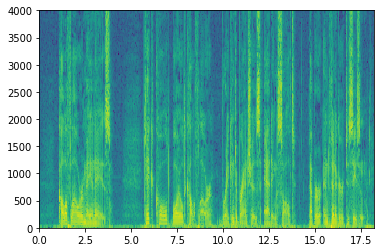

In [53]:
audio_gen = AudioGenerator()
audio_gen.load_train_data('D:/Data_ASR/train_corpus.json')